[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/data_augmentation/gan/gan_cnn.ipynb)


In [20]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torchvision
from torchvision.utils import make_grid

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **Dataset**

In [22]:
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [23]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Define the transformation to normalize the data between 1 and -1 (mean = 0.5 and variance = 0.5 will transform to values between 1 and -1)
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # downloading the MNIST train dataset and then applying some transformations
mnist_loader = DataLoader(dataset=mnist, batch_size=64, shuffle=True) # loading the downloaded dataset

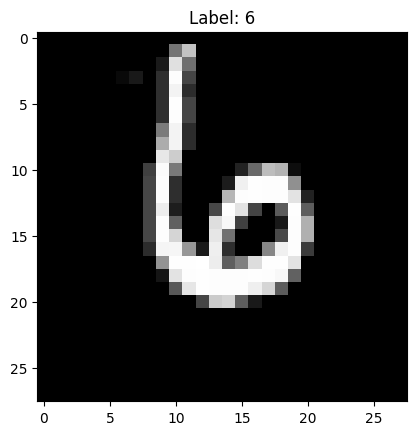

In [24]:
# Display one image from one of the batches
images, labels = next(iter(mnist_loader)) # Extract one batch of images and labels
image = images[0].numpy().squeeze() # loading the one image from that batch
label = labels[0].item() # loading the actual label of the above image

import matplotlib.pyplot as plt
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

# **Modelling**

In [25]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.ConvTranspose2d(100, 512, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), nn.BatchNorm2d(512),nn.ReLU(),
                                    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), nn.BatchNorm2d(256),nn.ReLU(),
                                    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.BatchNorm2d(128),nn.ReLU(),
                                    nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, output_padding=0, bias=False), nn.Identity(),nn.Tanh()
                                    )

    def forward(self, z):
        batch_size = z.shape[0]
        out = z.reshape(-1, 100, 1, 1) # reshaping
        out = self.layers(out)
        return out.reshape(batch_size, 1, 28, 28) # reshaping

In [26]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1, bias=True), nn.Identity(),nn.LeakyReLU(),
                                    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(256),nn.LeakyReLU(),
                                    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(512),nn.LeakyReLU(),
                                    nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1, bias=False), nn.Identity(),nn.Sigmoid(),
                                    )

    def forward(self, x):
        out = self.layers(x)
        return out.reshape(x.size(0))

# **Training**

In [27]:
noise_dim = 100

In [28]:
from torch.optim import Adam

# Instantiate generator model
generator = Generator().to(device)
generator.train()
optimizer_generator = Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999)) #0.5 is momentum

# Instantiate discriminator model
discriminator = Discriminator().to(device)
discriminator.train()
optimizer_discriminator = Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999)) #0.5 is momentum

In [ ]:
steps = 0
for epoch in range(50): # for each epoch
    generator_losses = []
    discriminator_losses = []
    mean_real_dis_preds = []
    mean_fake_dis_preds = []

    for im, _ in tqdm(mnist_loader): # for each image in each epoch

        real_ims = im.float().to(device)
        batch_size = real_ims.shape[0]

        ''' ######################### First Optimizing the Discriminator ######################### '''

        optimizer_discriminator.zero_grad()

        fake_im_noise = torch.randn((batch_size, noise_dim), device=device) # creating a noisy data
        fake_ims = generator(fake_im_noise) # passing the noisy data through the generator to get fake image
        disc_real_pred = discriminator(real_ims) # passing real image to the discriminator
        disc_fake_pred = discriminator(fake_ims.detach()) # passing fake image to the discriminator but we are detaching it so that gradients are not computed for generator and generator is not trained while training the discriminator

        disc_loss = -torch.mean(torch.log(disc_real_pred.reshape(-1) + 0.0001) + torch.log(1. - disc_fake_pred.reshape(-1) + 0.0001) )

        disc_loss.backward()
        optimizer_discriminator.step()

        mean_real_dis_preds.append(torch.nn.Sigmoid()(disc_real_pred).mean().item())
        mean_fake_dis_preds.append(torch.nn.Sigmoid()(disc_fake_pred).mean().item())


        ''' ######################### Second Optimizing the Generator ######################### '''
        optimizer_generator.zero_grad()

        fake_im_noise = torch.randn((batch_size, noise_dim), device=device) # creating a noisy data
        fake_ims = generator(fake_im_noise) # passing through generator to create fake image
        disc_fake_pred = discriminator(fake_ims) # passing through discriminator to classify it as fake or real

        gen_fake_loss = -torch.mean(torch.log(disc_fake_pred.reshape(-1) + 0.0001))

        gen_fake_loss.backward()
        optimizer_generator.step()

        generator_losses.append(gen_fake_loss.item())
        discriminator_losses.append(disc_loss.item())

        ''' ######################### Seeing how the generator is improving with training ######################### '''
        if steps % 5 == 0:
            with torch.no_grad():
                generator.eval()

                NUM_SAMPLES = 225
                fake_im_noise = torch.randn((NUM_SAMPLES, noise_dim), device=device) # generating some noisy data
                fake_ims = generator(fake_im_noise) # generating image using generator
                ims = torch.clamp(fake_ims, -1., 1.).detach().cpu() # clamping the generated images
                ims = 0.5*ims + 0.5 #detransforming the images from [-1,1] to [0,1]
                grid = make_grid(ims, nrow=15)
                img = torchvision.transforms.ToPILImage()(grid)
                plt.imshow(img, cmap='gray') # now display the image here using matplot lib

                generator.train()
        steps += 1

    print(f'''Finished epoch:{epoch + 1} | Generator Loss : {np.mean(generator_losses)} | Discriminator Loss : {np.mean(discriminator_losses)} | Discriminator real pred : {np.mean(mean_real_dis_preds)} | Discriminator fake pred : {np.mean(mean_fake_dis_preds)}''')

100%|██████████| 938/938 [01:43<00:00,  9.08it/s]


Finished epoch:1 | Generator Loss : 4.7217303567699025 | Discriminator Loss : 0.4995522443580551 | Discriminator real pred : 0.6972392385066953 | Discriminator fake pred : 0.5383390823025693


100%|██████████| 938/938 [01:37<00:00,  9.63it/s]


Finished epoch:2 | Generator Loss : 2.2327898537108637 | Discriminator Loss : 0.6596663472081806 | Discriminator real pred : 0.6818600326840049 | Discriminator fake pred : 0.5559455805114591


100%|██████████| 938/938 [01:37<00:00,  9.65it/s]


Finished epoch:3 | Generator Loss : 2.490932705845914 | Discriminator Loss : 0.5662667403247819 | Discriminator real pred : 0.688934474865765 | Discriminator fake pred : 0.5480169640548194


100%|██████████| 938/938 [01:37<00:00,  9.59it/s]


Finished epoch:4 | Generator Loss : 2.8486347038354447 | Discriminator Loss : 0.49335397703688283 | Discriminator real pred : 0.6945769526938131 | Discriminator fake pred : 0.5417847703260653


100%|██████████| 938/938 [01:37<00:00,  9.59it/s]


Finished epoch:5 | Generator Loss : 3.089547786790171 | Discriminator Loss : 0.4306384985253755 | Discriminator real pred : 0.6991779747039779 | Discriminator fake pred : 0.5365704123272317


100%|██████████| 938/938 [01:37<00:00,  9.64it/s]


Finished epoch:6 | Generator Loss : 3.4493725296340263 | Discriminator Loss : 0.3547577820559427 | Discriminator real pred : 0.7046862611257191 | Discriminator fake pred : 0.5302918329040633


100%|██████████| 938/938 [01:37<00:00,  9.66it/s]


Finished epoch:7 | Generator Loss : 3.6298759006170322 | Discriminator Loss : 0.32466712651222246 | Discriminator real pred : 0.7070374348397448 | Discriminator fake pred : 0.5277365159505466


100%|██████████| 938/938 [01:36<00:00,  9.69it/s]


Finished epoch:8 | Generator Loss : 3.822005818877965 | Discriminator Loss : 0.3088107062007255 | Discriminator real pred : 0.7086759372941975 | Discriminator fake pred : 0.5256802005045957


100%|██████████| 938/938 [01:36<00:00,  9.69it/s]


Finished epoch:9 | Generator Loss : 3.9336291999101385 | Discriminator Loss : 0.31289778015951614 | Discriminator real pred : 0.7090735697288757 | Discriminator fake pred : 0.5251727443514094


100%|██████████| 938/938 [01:36<00:00,  9.71it/s]


Finished epoch:10 | Generator Loss : 4.178221974355071 | Discriminator Loss : 0.23867134827532685 | Discriminator real pred : 0.7133380072965805 | Discriminator fake pred : 0.5205820821114441


100%|██████████| 938/938 [01:36<00:00,  9.72it/s]


Finished epoch:11 | Generator Loss : 4.23307359321857 | Discriminator Loss : 0.28475013635020013 | Discriminator real pred : 0.7111739790770036 | Discriminator fake pred : 0.5227867013482905


100%|██████████| 938/938 [01:36<00:00,  9.70it/s]


Finished epoch:12 | Generator Loss : 4.451990207692962 | Discriminator Loss : 0.20738382721399226 | Discriminator real pred : 0.71565594182594 | Discriminator fake pred : 0.5178708833163735


100%|██████████| 938/938 [01:36<00:00,  9.72it/s]


Finished epoch:13 | Generator Loss : 4.56090134788932 | Discriminator Loss : 0.24236972076393393 | Discriminator real pred : 0.7141585763075204 | Discriminator fake pred : 0.5192750802299361


100%|██████████| 938/938 [01:36<00:00,  9.71it/s]


Finished epoch:14 | Generator Loss : 4.681969227408295 | Discriminator Loss : 0.20070474446991454 | Discriminator real pred : 0.7166925093004191 | Discriminator fake pred : 0.5167555765175362


100%|██████████| 938/938 [01:36<00:00,  9.71it/s]


Finished epoch:15 | Generator Loss : 4.823602734693586 | Discriminator Loss : 0.1927872085784957 | Discriminator real pred : 0.7169917018682972 | Discriminator fake pred : 0.5162321041260701


100%|██████████| 938/938 [01:37<00:00,  9.66it/s]


Finished epoch:16 | Generator Loss : 4.85723292282713 | Discriminator Loss : 0.21484986730992223 | Discriminator real pred : 0.7162878923197545 | Discriminator fake pred : 0.5169718495564166


100%|██████████| 938/938 [01:36<00:00,  9.69it/s]


Finished epoch:17 | Generator Loss : 5.130104959265256 | Discriminator Loss : 0.13955004536397836 | Discriminator real pred : 0.7204997525540496 | Discriminator fake pred : 0.5122753109123661


100%|██████████| 938/938 [01:36<00:00,  9.72it/s]


Finished epoch:18 | Generator Loss : 5.015853127818118 | Discriminator Loss : 0.20453823115160344 | Discriminator real pred : 0.7171568082593905 | Discriminator fake pred : 0.5159628707081524


100%|██████████| 938/938 [01:36<00:00,  9.71it/s]


Finished epoch:19 | Generator Loss : 5.092197025127248 | Discriminator Loss : 0.17564398383916313 | Discriminator real pred : 0.7189174185810822 | Discriminator fake pred : 0.5140119179733781


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Finished epoch:20 | Generator Loss : 5.297482400560684 | Discriminator Loss : 0.16351183510059292 | Discriminator real pred : 0.7199348800345016 | Discriminator fake pred : 0.5126331524172826


100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


Finished epoch:21 | Generator Loss : 5.25757289809713 | Discriminator Loss : 0.15681248642270887 | Discriminator real pred : 0.7200973926703813 | Discriminator fake pred : 0.5127770709457682


100%|██████████| 938/938 [01:36<00:00,  9.72it/s]


Finished epoch:22 | Generator Loss : 5.3585173586792525 | Discriminator Loss : 0.15053041894418268 | Discriminator real pred : 0.7204694438463589 | Discriminator fake pred : 0.5122667971069116


100%|██████████| 938/938 [01:36<00:00,  9.77it/s]


Finished epoch:23 | Generator Loss : 5.412193372019573 | Discriminator Loss : 0.16969197698936328 | Discriminator real pred : 0.7196439901775897 | Discriminator fake pred : 0.513056283058134


100%|██████████| 938/938 [01:36<00:00,  9.72it/s]


Finished epoch:24 | Generator Loss : 5.655939541900081 | Discriminator Loss : 0.1277039710738595 | Discriminator real pred : 0.7221406755416886 | Discriminator fake pred : 0.5102986466528764


100%|██████████| 938/938 [01:37<00:00,  9.61it/s]


Finished epoch:25 | Generator Loss : 5.389177391754348 | Discriminator Loss : 0.15697402965256582 | Discriminator real pred : 0.7206540279932367 | Discriminator fake pred : 0.5120099134790872


100%|██████████| 938/938 [01:36<00:00,  9.70it/s]


Finished epoch:26 | Generator Loss : 5.65216352897031 | Discriminator Loss : 0.12848457327481907 | Discriminator real pred : 0.7223460998362315 | Discriminator fake pred : 0.5100758720689745


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Finished epoch:27 | Generator Loss : 5.832754401668811 | Discriminator Loss : 0.12258883056328641 | Discriminator real pred : 0.7226475126453554 | Discriminator fake pred : 0.5097441014323407


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Finished epoch:28 | Generator Loss : 5.529808963643018 | Discriminator Loss : 0.1677428897833134 | Discriminator real pred : 0.7202282691561083 | Discriminator fake pred : 0.5123595165164232


100%|██████████| 938/938 [01:36<00:00,  9.67it/s]


Finished epoch:29 | Generator Loss : 5.797351174358366 | Discriminator Loss : 0.1178974831657512 | Discriminator real pred : 0.723193299478051 | Discriminator fake pred : 0.5091326892503035


100%|██████████| 938/938 [01:36<00:00,  9.71it/s]


Finished epoch:30 | Generator Loss : 5.831953049881626 | Discriminator Loss : 0.1522942513829645 | Discriminator real pred : 0.7212936688206597 | Discriminator fake pred : 0.5111493405375653


100%|██████████| 938/938 [01:36<00:00,  9.72it/s]


Finished epoch:31 | Generator Loss : 5.795725500914079 | Discriminator Loss : 0.11670574102265788 | Discriminator real pred : 0.7228238976586348 | Discriminator fake pred : 0.5095636889751531


100%|██████████| 938/938 [01:36<00:00,  9.76it/s]


Finished epoch:32 | Generator Loss : 6.065631920213638 | Discriminator Loss : 0.10161133629551876 | Discriminator real pred : 0.7240175434521267 | Discriminator fake pred : 0.5081025336597011


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Finished epoch:33 | Generator Loss : 6.10712074359724 | Discriminator Loss : 0.10778944300654442 | Discriminator real pred : 0.7238478917938306 | Discriminator fake pred : 0.5083989381535984


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Finished epoch:34 | Generator Loss : 6.01863079557795 | Discriminator Loss : 0.1303892042365611 | Discriminator real pred : 0.7225050938917376 | Discriminator fake pred : 0.5097888175612574


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Finished epoch:35 | Generator Loss : 6.225022054636783 | Discriminator Loss : 0.08991133762987208 | Discriminator real pred : 0.7246027717839426 | Discriminator fake pred : 0.5075064128650023


100%|██████████| 938/938 [01:36<00:00,  9.71it/s]


Finished epoch:36 | Generator Loss : 6.237529257975662 | Discriminator Loss : 0.11883301746464078 | Discriminator real pred : 0.7233240719415994 | Discriminator fake pred : 0.5088149292001338


100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


Finished epoch:37 | Generator Loss : 6.204241300474352 | Discriminator Loss : 0.1095781275042348 | Discriminator real pred : 0.7241437752872134 | Discriminator fake pred : 0.5079586125258952


100%|██████████| 938/938 [01:36<00:00,  9.76it/s]


Finished epoch:38 | Generator Loss : 6.38122997755435 | Discriminator Loss : 0.08471914719981846 | Discriminator real pred : 0.7251840895299972 | Discriminator fake pred : 0.5067772593960833


100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


Finished epoch:39 | Generator Loss : 6.318194305909468 | Discriminator Loss : 0.09178510943017747 | Discriminator real pred : 0.7247365708671399 | Discriminator fake pred : 0.5073098553014971


100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Finished epoch:40 | Generator Loss : 6.308816900194835 | Discriminator Loss : 0.08765139442303581 | Discriminator real pred : 0.7250539594367623 | Discriminator fake pred : 0.5069652236600929


100%|██████████| 938/938 [01:36<00:00,  9.72it/s]


Finished epoch:41 | Generator Loss : 6.3224260075323615 | Discriminator Loss : 0.12887921955757664 | Discriminator real pred : 0.7235222917629965 | Discriminator fake pred : 0.5085008195849624


100%|██████████| 938/938 [01:36<00:00,  9.74it/s]


Finished epoch:42 | Generator Loss : 6.443995843182749 | Discriminator Loss : 0.08638313998781164 | Discriminator real pred : 0.7253247118835002 | Discriminator fake pred : 0.5066302061589287


100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


Finished epoch:43 | Generator Loss : 6.478608952878889 | Discriminator Loss : 0.07266489610649092 | Discriminator real pred : 0.7260770802813044 | Discriminator fake pred : 0.505797371681311


100%|██████████| 938/938 [01:36<00:00,  9.71it/s]


Finished epoch:44 | Generator Loss : 6.30012497969909 | Discriminator Loss : 0.10590106000523589 | Discriminator real pred : 0.7244391047369951 | Discriminator fake pred : 0.5075811261434291


100%|██████████| 938/938 [01:36<00:00,  9.77it/s]


Finished epoch:45 | Generator Loss : 6.594545263789102 | Discriminator Loss : 0.07691723622175912 | Discriminator real pred : 0.726095845259583 | Discriminator fake pred : 0.50579165465542


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


Finished epoch:46 | Generator Loss : 6.661577849023378 | Discriminator Loss : 0.06807310906080179 | Discriminator real pred : 0.7262484821429385 | Discriminator fake pred : 0.505563443022242


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


Finished epoch:47 | Generator Loss : 6.619582347841914 | Discriminator Loss : 0.090801583902192 | Discriminator real pred : 0.7257241581294582 | Discriminator fake pred : 0.5060377899390548


100%|██████████| 938/938 [01:35<00:00,  9.79it/s]


Finished epoch:48 | Generator Loss : 6.330615983016964 | Discriminator Loss : 0.14116849665665182 | Discriminator real pred : 0.7227717791157745 | Discriminator fake pred : 0.5093362860079768


100%|██████████| 938/938 [01:36<00:00,  9.77it/s]


Finished epoch:49 | Generator Loss : 6.649519353406007 | Discriminator Loss : 0.059165705681009255 | Discriminator real pred : 0.7267668697752678 | Discriminator fake pred : 0.5050442687102726


 10%|█         | 97/938 [00:10<01:23, 10.01it/s]

Key things to note in above training errors :

1. First discriminator loss decreases while generator loss increases => because initially only discriminator is being trained
2. Then the discriminator loss remains constant and the generator loss decreases => because now the discriminator is freezed and the generator is being trained

# **Inference**

In [ ]:
NUM_SAMPLES = 225
fake_im_noise = torch.randn((NUM_SAMPLES, noise_dim), device=device) # generating some noisy data
generated_ims = generator(fake_im_noise) # generating image using generator

In [ ]:
generated_ims = torch.clamp(generated_ims, -1., 1.).detach().cpu() # clamping the generated images
generated_ims = 0.5*generated_ims + 0.5 #detransforming the images from [-1,1] to [0,1]

In [ ]:
# now printing the predicted images
grid = torchvision.utils.make_grid(generated_ims, nrow=15)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img, cmap='gray') # now display the image here using matplot lib